In [3]:
%load_ext autoreload
%autoreload 2
%pylab inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
import sys
sys.path.append('/mnt/home/cmodi/.local/lib/python3.8/site-packages/')

### Load CLASS

In [5]:
import nbodykit
from nbodykit.cosmology import LinearPower, Cosmology, Planck15, HalofitPower


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [6]:
# Cosmology.LinearPower()

In [7]:
# from classy import Class
# cosmo = Class()
# cosmo.set({'output':'mPk','omega_b':0.022,'omega_cdm':0.12,'h':0.67,'sigma8':0.8,'n_s':0.96})
# cosmo.compute()

cosmo = Planck15
pklin = LinearPower(cosmo, 0.0)
pkhf = HalofitPower(cosmo, 0.0)


### Compute linear power spectrum

In [8]:
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.integrate import simps


z = 0.
k_arr = np.geomspace(1e-6,10,100)
# cosmo = cosmo.clone(Omega0_b = 0.05)
pklin = LinearPower(cosmo, 0.0)
pk_arr = pklin(k_arr)
PkL = InterpolatedUnivariateSpline(k_arr,pk_arr,ext='zeros')


In [9]:
def get_ps(Omega0_m, Omega0_b, h, ns, sigma_8):

    Omega0_cdm = Omega0_m - Omega0_b
    cosmo = Planck15.clone(Omega0_cdm=Omega0_cdm, Omega0_b=Omega0_b, h=h, n_s=ns, sigma_8=sigma_8)
    # cosmo = Planck15.clone(**{'Omega0_cdm':Omega0_cdm, 'Omega0_b':Omega0_b, 'h':h, 'n_s':ns, 'ln10^{10}A_s': 2.13})
    print(cosmo.parameter_dict)
    k_arr = np.geomspace(1e-6,20,1000)
    pklin = LinearPower(cosmo, 0.0, transfer='CLASS')
    pk_arr = pklin(k_arr)
    PkL = InterpolatedUnivariateSpline(k_arr,pk_arr,ext='zeros')
    return PkL


get_ps(0.3, 0.05, 0.67, 0.966, 0.8)

/mnt/home/cmodi/.local/lib/python3.8/site-packages/nbodykit/cosmology/cosmology.py:427: UserWarning: Class did not read input parameter(s): sigma_8
  self.engine = ClassEngine(pars)


{'Alpha_inf hyrec file': '/mnt/home/cmodi/.local/lib/python3.8/site-packages/classylss/data/hyrec/Alpha_inf.dat', 'N_ncdm': '1', 'N_ur': '2.0328', 'Omega_b': '0.05', 'Omega_cdm': '0.25', 'Omega_k': '0.0', 'P_k_max_h/Mpc': '10.0', 'R_inf hyrec file': '/mnt/home/cmodi/.local/lib/python3.8/site-packages/classylss/data/hyrec/R_inf.dat', 'T_cmb': '2.7255', 'extra metric transfer functions': 'y', 'gauge': 'synchronous', 'h': '0.67', 'k_pivot': '0.05', 'ln10^{10}A_s': '3.064', 'm_ncdm': '0.06', 'n_s': '0.966', 'output': 'vTk dTk mPk', 'sBBN file': '/mnt/home/cmodi/.local/lib/python3.8/site-packages/classylss/data/bbn/sBBN.dat', 'sigma_8': '0.8', 'tau_reio': '0.066', 'two_photon_tables hyrec file': '/mnt/home/cmodi/.local/lib/python3.8/site-packages/classylss/data/hyrec/two_photon_tables.dat', 'z_max_pk': '100.0'}


### Compute $P_{13}$

In [410]:
r_arr = np.geomspace(1e-5,9e4,1001)[None,:]
P13_pref = k_arr**3/(252.*(2.*np.pi)**2)*PkL(k_arr)
P13_integ = lambda r: 12./r**4.-158./r**2.+100.-42.*r**2+3./r**5.*(7.*r**2+2)*(r**2-1.)**3.*np.log(np.abs((r+1.)/(r-1.)))
P13_raw = P13_pref*simps(r_arr**2*PkL(r_arr*k_arr[:,None])*P13_integ(r_arr),r_arr)
P13 = InterpolatedUnivariateSpline(k_arr,P13_raw,ext='zeros')

## Compute $P_{22}$

In [411]:
from scipy.special import p_roots
mu_arr,w_arr = p_roots(100) # Gauss-Legendre quadrature weights
mu_arr = mu_arr[None,None,:]
w_arr = w_arr[None,None,:]
P22_pref = k_arr**3./(2.*np.pi**2)
psi_arr = np.sqrt(1.+r_arr[:,:,None]**2-2*r_arr[:,:,None]*mu_arr)
F_2d = lambda r, mu: (7.*mu+(3.-10.*mu**2)*r)/(14.*r*(r**2-2.*r*mu+1.))
mu_integral = np.sum(w_arr*PkL(k_arr[:,None,None]*psi_arr)*np.abs(F_2d(r_arr[:,:,None],mu_arr))**2.,axis=2)
P22_raw = P22_pref*simps(r_arr**2*PkL(r_arr*k_arr[:,None])*mu_integral,r_arr,axis=1)
P22 = InterpolatedUnivariateSpline(k_arr,P22_raw,ext='zeros')

## Compute counterterm

In [412]:
Pct = lambda k,cs: -2.*cs*k**2*PkL(k)

# Class it

In [28]:
# from scipy.special import p_roots

# class PkMatter:
    
#     def __init__(self):
#         self.k_arr = np.geomspace(1e-6,10,100)
#         self.r_arr = np.geomspace(1e-5,9e4,1001)[None,:]
#         mu_arr, w_arr = p_roots(100) # Gauss-Legendre quadrature weights
#         self.mu_arr = mu_arr[None,None,:]
#         self.w_arr = w_arr[None,None,:]        
#         self.psi_arr = np.sqrt(1.+self.r_arr[:,:,None]**2-2*self.r_arr[:,:,None]*self.mu_arr)
        

#         self.F_2d = lambda r, mu: (7.*mu+(3.-10.*mu**2)*r)/(14.*r*(r**2-2.*r*mu+1.))
#         self.F_2d_r_mu_factor = np.abs(self.F_2d(self.r_arr[:,:,None],self.mu_arr))**2.
#         self.P22_pref = self.k_arr**3./(2.*np.pi**2)
        
#         self.P13_integ = lambda r: 12./r**4.-158./r**2.+100.-42.*r**2+3./r**5.*(7.*r**2+2)*(r**2-1.)**3.*np.log(np.abs((r+1.)/(r-1.)))
        
#         self.P13_integ_rarr = self.P13_integ(r_arr)
        
#     def p13(self, pkl):
#         P13_pref = self.k_arr**3/(252.*(2.*np.pi)**2)*pkl(self.k_arr)
#         integrand = self.r_arr**2*pkl(self.r_arr*self.k_arr[:,None])*self.P13_integ_rarr
#         P13_raw = P13_pref*simps(integrand, self.r_arr)
#         P13 = InterpolatedUnivariateSpline(self.k_arr, P13_raw, ext='zeros')
#         return P13
            
#     def p22(self, pkl):
        
#         mu_integral = np.sum(self.w_arr* pkl(self.k_arr[:,None,None]*self.psi_arr) *self.F_2d_r_mu_factor, axis=2)
#         P22_raw = self.P22_pref * simps(self.r_arr**2* pkl(self.r_arr*self.k_arr[:,None])* mu_integral, r_arr, axis=1)
#         P22 = InterpolatedUnivariateSpline(self.k_arr, P22_raw, ext='zeros')
#         return P22
    
#     def pct(self, pkl):
        
#         return lambda k,cs: -2.*cs*k**2*pkl(k)



## Plot
- Using $c_s = 1$ for visualization only.

(0.005, 0.1)

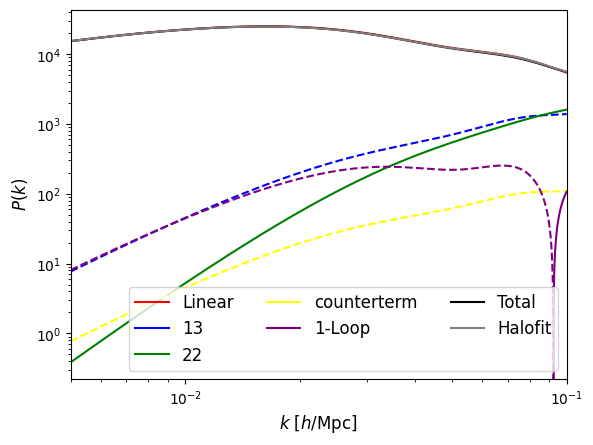

In [414]:
k_plot = np.geomspace(5e-3,0.1,1000)
def plot(spec,label,col):
    plt.plot(k_plot,spec(k_plot),label=label,c=col)
    plt.plot(k_plot,-spec(k_plot),c=col,ls='--')
plot(PkL,'Linear','r')
plot(P13,'13','b')
plot(P22,'22','g')
plot(lambda k: Pct(k, 1.0),'counterterm','yellow')
plot(lambda k: P22(k)+P13(k)+Pct(k,1.0),'1-Loop','purple')
plot(lambda k: PkL(k)+P22(k)+P13(k)+Pct(k,1.0),'Total','k')
plot(pkhf,'Halofit','grey')

plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=12,ncol=3)
plt.xlabel(r'$k$ $[h/\mathrm{Mpc}]$',fontsize=12)
plt.ylabel(r'$P(k)$',fontsize=12)
plt.xlim(min(k_plot),max(k_plot))

[]

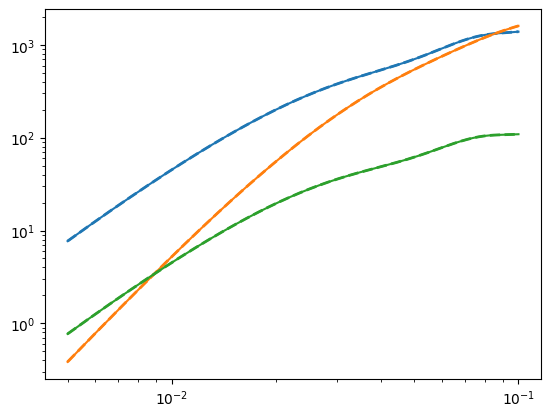

In [415]:
pkmatter = PkMatter()

plt.plot(k_plot, abs(pkmatter.p13(PkL)(k_plot)), 'C0')
plt.plot(k_plot, abs(P13(k_plot)), 'C0--', lw=2)

plt.plot(k_plot, abs(pkmatter.p22(PkL)(k_plot)), 'C1')
plt.plot(k_plot, abs(P22(k_plot)), 'C1--', lw=2)

plt.plot(k_plot, abs(pkmatter.pct(PkL)(k_plot, 1)), 'C2')
plt.plot(k_plot, abs(Pct(k_plot, 1)), 'C2--', lw=2)

plt.loglog()

In [57]:
%timeit P22(k_plot)

41.6 µs ± 1.17 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [58]:
%timeit P13(k_plot)

41.1 µs ± 16 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Load from src


In [29]:

sys.path.append('../src/')

import pt
pklin_nb = pt.NBPklin()

/mnt/home/cmodi/.local/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:832: AccuracyWarning: divmax (10) exceeded. Latest difference = 1.382196e-06
  warnings.warn(


# Inference

In [15]:
# import zeus
# import numpy as np

# def log_prob(x, ivar):
#     return - 0.5 * np.sum(ivar * x**2.0)

# nsteps, nwalkers, ndim = 1000, 100, 10
# ivar = 1.0 / np.random.rand(ndim)
# start = np.random.randn(nwalkers,ndim)

# sampler = zeus.EnsembleSampler(nwalkers, ndim, log_prob, args=[ivar])
# sampler.run_mcmc(start, nsteps)
# chain = sampler.get_chain(flat=False)

Initialising ensemble of 100 walkers...
Sampling progress : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 205.16it/s]


In [16]:
chain.shape

(1000, 100, 10)

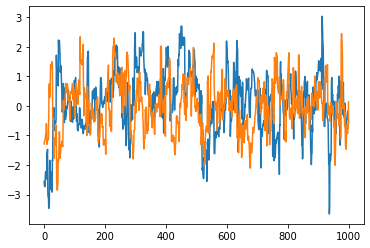

In [18]:
plt.plot(chain[:, 0, 0])
plt.plot(chain[:, 1, 0])

# linear power spectra

In [31]:
import sys, os
sys.path.append('../src/')

import loader_pk
import sbitools, sbiplots

args = {"kmin": 0.01, "kmax":0.3, "offset_amp":0, "ampnorm":False}
args = sbitools.Objectify(args)
kcut, features, params = loader_pk.loader(args, return_k=True)


Loaded power spectrum data with shape :  (2000, 128)
pk shape after k-cuts :  (2000, 46)


In [ ]:
cosmo.sigma8, params[1]

(0.8115989991976709, array([0.2139 , 0.05557, 0.8599 , 0.9785 , 0.8619 ]))

In [222]:
# !cat '/mnt/ceph/users/fvillaescusa/Quijote/Linear_Pk/latin_hypercube/5/CAMB.params';

[0.1821  0.04809 0.5865  0.9565  0.8101 ]


/mnt/home/cmodi/.local/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:832: AccuracyWarning: divmax (10) exceeded. Latest difference = 2.110450e-06
  warnings.warn(
/tmp/ipykernel_3767994/2416612491.py:17: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


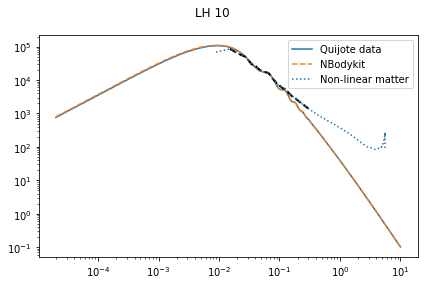

In [34]:
i = 10
print(params[i])
pss = pklin_nb(*list(params[i]))
klin, plin = np.loadtxt(f'/mnt/ceph/users/fvillaescusa/Quijote/Linear_Pk/latin_hypercube/{i}/Pk_mm_z=0.000.txt').T
normfac = loadtxt(f'/mnt/ceph/users/fvillaescusa/Quijote/Linear_Pk/latin_hypercube/{i}/Normfac.txt')
knlin, pknlin = np.loadtxt(f'/mnt/ceph/users/fvillaescusa/Quijote/Pk/matter/latin_hypercube/{i}/Pk_m_z=0.txt').T
plin *= normfac

plt.plot(klin, plin, 'C0', label='Quijote data')
plt.plot(klin, pss(klin), 'C1--', label='NBodykit')
plt.plot(kcut, features[i], 'k--', lw=2)
plt.plot(knlin, pknlin, 'C0:', label='Non-linear matter')

plt.loglog()
plt.legend()
plt.suptitle(f'LH {i}')
plt.show()
plt.tight_layout()

[]

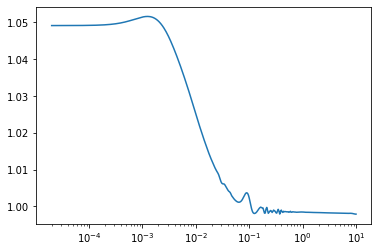

In [35]:
plt.plot(klin, pss(klin)/plin)
plt.semilogx()

# train MLP

In [36]:
# trainset = []
# for i in range(2000):
#     klin, plin = np.loadtxt(f'/mnt/ceph/users/fvillaescusa/Quijote/Linear_Pk/latin_hypercube/{i}/Pk_mm_z=0.000.txt').T
#     normfac = loadtxt(f'/mnt/ceph/users/fvillaescusa/Quijote/Linear_Pk/latin_hypercube/{i}/Normfac.txt')
#     trainset.append(plin*normfac)

# trainset = np.array(trainset)

In [43]:
# klin, plin = np.loadtxt(f'/mnt/ceph/users/fvillaescusa/Quijote/Linear_Pk/latin_hypercube/{i}/Pk_mm_z=0.000.txt').T
# np.save('../data/klin_quijote.npy', klin)

In [159]:
params = np.load('/mnt/ceph/users/cmodi/Quijote/params_lh.npy')
trainset_raw = np.load('../data/pklin_quijote_lextrap.npy')
ktrain = np.load('../data/klin_quijote_lextrap.npy')
# trainset = np.load('../data/pklin_quijote_lextrap.npy')
# trainset = np.log(trainset)
# loc, scale = trainset.mean(axis=0), trainset.std(axis=0)
# trainset = (trainset - loc)/scale

(-7.307755032155716, 3.3264650379432585)

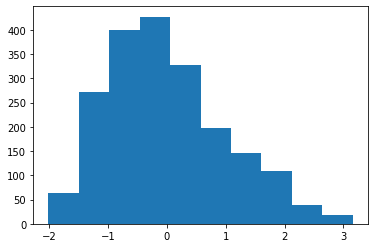

In [143]:
plt.hist(trainset[:, 200]);
trainset.min(), trainset.max()

In [345]:
import torch
from torch import nn
from utils import BoltzNet

model = BoltzNet(d_in=5, d_out=500, nhidden=1000, loc=loc, scale=scale)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.998)
losses = []


In [346]:
X = torch.from_numpy(params.astype(np.float32))
Y = torch.from_numpy(trainset.astype(np.float32))

In [347]:
1e-3*(0.998)**2000 / 1e-5

1.8242425223750636

In [ ]:
# niter = 20000
nepochs = 2000
batch = 40
for epoch in range(nepochs):
    idxp = np.random.permutation(np.arange(2000))
    if epoch %50 == 0: print(epoch)
    for n in range(2000//batch):
        idx = idxp[n*batch : (n+1)*batch]
        y_pred = model(X[idx])
        loss = loss_fn(y_pred, Y[idx])
        losses.append(loss.detach())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700


In [ ]:
plt.plot(losses)
plt.loglog()

In [ ]:
# model.save_model('../data/boltznet/dummy')

In [ ]:
optimizer.state_dict

In [ ]:
y_pred = model.predict(X)


In [ ]:
i = np.random.randint(0, 2000) 
print(i, params[i])

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(ktrain, y_pred[i])
plt.plot(ktrain, trainset_raw[i])
plt.loglog()
plt.subplot(122)
plt.plot(ktrain, y_pred[i]/trainset_raw[i])
plt.semilogx()
plt.axhline(1, color='k')

In [ ]:
yratio = (y_pred/trainset_raw)
yratio.min(), yratio.max()

In [ ]:
plt.hist((y_pred/trainset_raw).flatten(), bins='auto');

In [ ]:
(yratio < 0.95).sum()/ yratio.size, (yratio > 1.05).sum()/ yratio.size

In [278]:
(yratio < 0.98).sum()/ yratio.size, (yratio > 1.02).sum()/ yratio.size

(0.071864, 0.042898)

In [246]:
(yratio < 0.95).sum()/ yratio.size, (yratio > 1.05).sum()/ yratio.size

(0.097731, 0.079196)

In [173]:
(yratio < 0.95).sum()/ yratio.size, (yratio > 1.05).sum()/ yratio.size

(0.014641, 0.021098)

In [318]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

in_layer.weight 	 torch.Size([1000, 5])
in_layer.bias 	 torch.Size([1000])
hidden_layers0.weight 	 torch.Size([1000, 1000])
hidden_layers0.bias 	 torch.Size([1000])
hidden_layers1.weight 	 torch.Size([1000, 1000])
hidden_layers1.bias 	 torch.Size([1000])
out_layer.weight 	 torch.Size([500, 1000])
out_layer.bias 	 torch.Size([500])


In [321]:
# torch.save(model.state_dict(), '../data/boltznet/test')

In [ ]:
model2 = BoltzNet(d_in=5, d_out=500, nhidden=1000, loc=loc, scale=scale)

model2.load_state_dict(torch.load('../data/boltznet/test'))

<All keys matched successfully>

In [331]:
y_pred2 = model2.predict(X)



In [334]:
model3 = BoltzNet(d_in=5, d_out=500, nhidden=1000, loc=loc, scale=scale)

model3.load_model('../data/boltznet/dummy')
y_pred3 = model3.predict(X)


In [85]:
i = np.random.randint(2000)
print(i)

psnn = InterpolatedUnivariateSpline(klin, trainset_raw[i], ext=0)
# psnn = InterpolatedUnivariateSpline(klin, y_pred[i], ext=0)
# psq = InterpolatedUnivariateSpline(klin, trainset_raw[i], ext=0)
# psnn = loginterp(klin, y_pred[i], lp=3, rp=-3);
psq = loginterp(klin, trainset_raw[i], lp=3, rp=-3);


44
0.9392860769587263 -2.589472539251249
0.9504718762086117 -2.589472538889777


In [86]:
pkmatter = pt.PkMatter()

[]

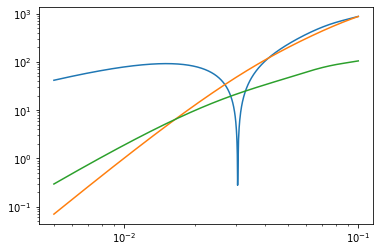

In [87]:
k_plot  = np.geomspace(5e-3, 0.1, 1000)

plt.plot(k_plot, abs(pkmatter.p13(psq)(k_plot)), 'C0')
# plt.plot(k_plot, abs(pkmatter.p13(psnn)(k_plot)), 'C0--', lw=2)

plt.plot(k_plot, abs(pkmatter.p22(psq)(k_plot)), 'C1')
# plt.plot(k_plot, abs(pkmatter.p22(psnn)(k_plot)), 'C1--', lw=2)

plt.plot(k_plot, abs(pkmatter.pct(psq)(k_plot, 1)), 'C2')
# plt.plot(k_plot, abs(pkmatter.pct(psnn)(k_plot, 1)), 'C2--', lw=2)
# 
plt.loglog()

[]

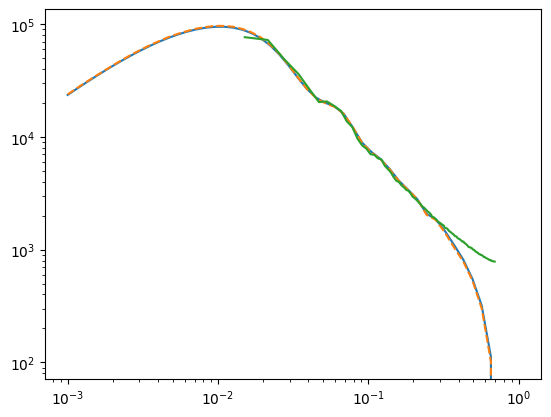

In [485]:
# plot(lambda k: PkL(k)+P22(k)+P13(k)+Pct(k,1.0),'Total','k')

k = np.logspace(-3, 0)
plt.plot(k, psq(k) + pkmatter.p13(psq)(k) + \
         pkmatter.p22(psq)(k) + \
          pkmatter.pct(psq)(k, 1))
plt.plot(k, psnn(k) + pkmatter.p13(psnn)(k) + \
         pkmatter.p22(psnn)(k) + \
          pkmatter.pct(psnn)(k, 1), '--')
plt.plot(kcut, features[i])
plt.loglog()

[]

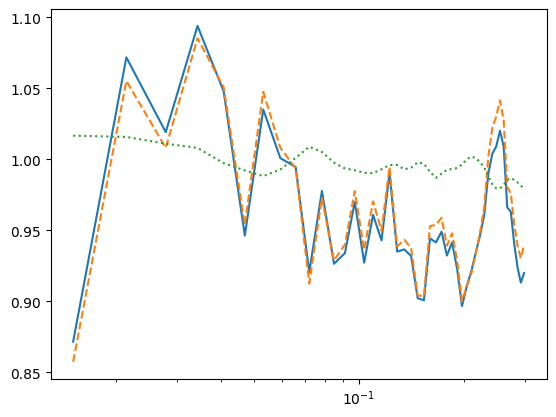

In [494]:
# plot(lambda k: PkL(k)+P22(k)+P13(k)+Pct(k,1.0),'Total','k')

k = kcut
plt.plot(k, features[i] / (psq(k) + pkmatter.p13(psq)(k) + \
         pkmatter.p22(psq)(k) + \
          pkmatter.pct(psq)(k, 0.1)))
plt.plot(k, features[i] / (psnn(k) + pkmatter.p13(psnn)(k) + \
         pkmatter.p22(psnn)(k) + \
          pkmatter.pct(psnn)(k, 0.1)), '--')
plt.plot(k, (psnn(k) + pkmatter.p13(psnn)(k) + \
         pkmatter.p22(psnn)(k) + \
          pkmatter.pct(psnn)(k, 0.1)) / (psq(k) + pkmatter.p13(psq)(k) + \
         pkmatter.p22(psq)(k) + \
          pkmatter.pct(psq)(k, 0.1)), ':')
# plt.plot(kcut, features[i])
plt.semilogx()


In [141]:

def sigmasqr(R, pk, kmin=0.00001, kmax=1000.0):
    """Computes the energy of the fluctuations within a sphere of R h^{-1} Mpc
    .. math::
       \\sigma^2(R)= \\frac{1}{2 \\pi^2} \\int_0^\\infty \\frac{dk}{k} k^3 P(k,z) W^2(kR)
    where
    .. math::
       W(kR) = \\frac{3j_1(kR)}{kR}

    Code taken from jax-cosmo: https://github.com/DifferentiableUniverseInitiative/jax_cosmo/blob/master/jax_cosmo/power.py
    """

    def int_sigma(logk):
        k = np.exp(logk)
        x = k * R
        w = 3.0 * (np.sin(x) - x * np.cos(x)) / (x * x * x)
        pk_arr = pk(k) 
        return k * (k * w) ** 2 * pk_arr

    y = romberg(int_sigma, np.log10(kmin), np.log10(kmax), divmax=10)
    return 1.0 / (2.0 * np.pi ** 2.0) * y


In [142]:
from scipy.integrate import romberg, romb

In [143]:
sigmasqr(8, PkL)**0.5


/mnt/home/cmodi/.local/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:832: AccuracyWarning: divmax (10) exceeded. Latest difference = 6.116131e-06
  warnings.warn(


0.8158535973802189

In [154]:
pkl1 = get_ps(0.3, 0.05, 0.67, 0.966, 0.83)
sigmac = sigmasqr(8, pkl1)**0.5
print(sigmac) 

pkl2 = lambda k: pkl1(k)*0.83**2/sigmac**2
sigmac2 = sigmasqr(8, pkl2)**0.5
print(sigmac2) 



{'Alpha_inf hyrec file': '/mnt/home/cmodi/.local/lib/python3.8/site-packages/classylss/data/hyrec/Alpha_inf.dat', 'N_ncdm': '1', 'N_ur': '2.0328', 'Omega_b': '0.05', 'Omega_cdm': '0.25', 'Omega_k': '0.0', 'P_k_max_h/Mpc': '10.0', 'R_inf hyrec file': '/mnt/home/cmodi/.local/lib/python3.8/site-packages/classylss/data/hyrec/R_inf.dat', 'T_cmb': '2.7255', 'extra metric transfer functions': 'y', 'gauge': 'synchronous', 'h': '0.67', 'k_pivot': '0.05', 'ln10^{10}A_s': '3.064', 'm_ncdm': '0.06', 'n_s': '0.966', 'output': 'vTk dTk mPk', 'sBBN file': '/mnt/home/cmodi/.local/lib/python3.8/site-packages/classylss/data/bbn/sBBN.dat', 'sigma_8': '0.83', 'tau_reio': '0.066', 'two_photon_tables hyrec file': '/mnt/home/cmodi/.local/lib/python3.8/site-packages/classylss/data/hyrec/two_photon_tables.dat', 'z_max_pk': '100.0'}
0.7832602599761079
0.8300000000000001


/mnt/home/cmodi/.local/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:832: AccuracyWarning: divmax (10) exceeded. Latest difference = 4.290732e-06
  warnings.warn(


[]

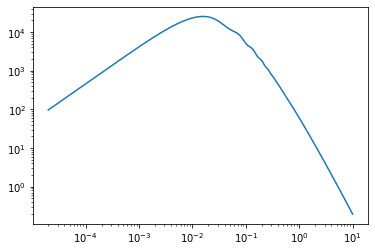

In [150]:
plt.plot(klin, pkl1(klin))
plt.loglog()

[]

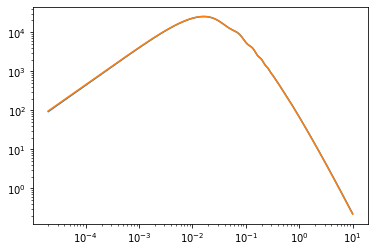

In [165]:
plt.plot(klin, LinearPower(cosmo, 0)(klin))
plt.plot(klin, LinearPower(cosmo2, 0)(klin))
plt.loglog()

# Extrapolate Quijote power spectrum

In [92]:
del loginterp

In [93]:
from utils import loginterp

In [97]:
pklinq = np.load('../data/pklin_quijote.npy')
klinq = np.load('../data/klin_quijote.npy')
ksave = np.geomspace(1e-6, 20, 500)

In [96]:
klinq.min(), klinq.max()

(2e-05, 10.000000000000012)

646


[]

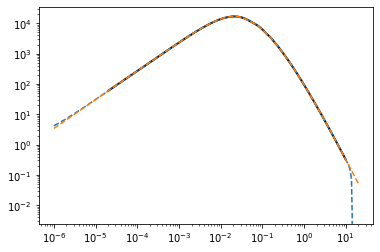

In [112]:
i = np.random.randint(2000)
print(i)
ilpk = loginterp(klinq, pklinq[i], verbose=False) 
plt.plot(klinq, pklinq[i], lw=2, color='k')
plt.plot(ksave, InterpolatedUnivariateSpline(klinq, pklinq[i])(ksave), '--')
plt.plot(ksave, ilpk(ksave), '--')
plt.loglog()

In [113]:
# pk_extrap = np.zeros((2000, ksave.size))

# for i in range(2000):
#     if i%100 == 0 : print(i)
#     pk_extrap[i] = loginterp(klinq, pklinq[i], verbose=False)(ksave)
    


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


[]

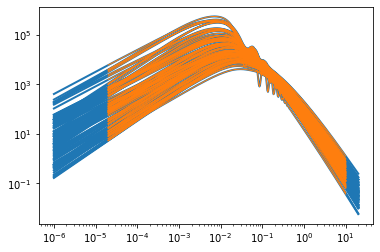

In [137]:
# i = np.random.randint(0, 2000, 100)

# plt.plot(ksave, pk_extrap[i].T, lw=2, color='C0')
# plt.plot(klinq, pklinq[i].T, lw=1, color='C1')
# plt.loglog()

In [138]:
# np.save('../data/pklin_quijote_lextrap.npy', pk_extrap)
# np.save('../data/klin_quijote_lextrap.npy', ksave)